# Prediction of Forest cover type

## Load Dataset

## Import Packages

In [1]:
#Import basic packages

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import pandas_profiling
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
%matplotlib inline


In [2]:
!ls

2015.csv
2016.csv
Applications
Country-Code.xlsx
DT&RFAss sol.ipynb
Desktop
Diabetes data.csv
Documents
Downloads
Eda@zomato.ipynb
Football EDA Project@Niharika.ipynb
Iron_mining.xls
Kaggle Housing Project.ipynb
Library
Linear_regression-UPX .ipynb
Linear_regression_assignment_Solution (1).ipynb
Logistic Regression-UPX.ipynb
Matplotlib assignment.ipynb
Matplotlib.ipynb
Matplotlib_seaborn.ipynb
Movies
Music
Normal way kaggle.ipynb
Numpy.ipynb
Numpy_Assignment_Solutions.ipynb
Pandas Assignment.ipynb
Pandas_Assignment_Solutions.ipynb
Pictures
Pipelining!.ipynb
Public
PycharmProjects
PythonBasics_notebook.ipynb
Sales_prediction_EDA_final.ipynb
Seaborn_Assignment.ipynb
Stacking_Forest.ipynb
Telecom Attack-Binary.ipynb
Telecom Attack-Multiclass.ipynb
Tesla Stock Price Prediction@Niharika.ipynb
Tesla.csv - Tesla.csv.csv
Test_Retail.csv
Titanic Submission1-Copy2.ipynb
Titanic Submission1.ipynb
Titanic87-Copy1.ipynb
Titanic87.ipynb
TitanicV1.ipynb
Train_Retail.csv
Untitled.ipynb
Untitled1.ipynb

## Read data

### 1. Through Pandas

In [3]:
# Read data through Pandas and compute time taken to read

t_start = time.time()
df_forest = pd.read_csv('stacking_forest.csv')
t_end = time.time()
print('pd.read_csv(): {} s'.format(t_end-t_start)) # time [s]
df_forest.head()

pd.read_csv(): 0.12501287460327148 s


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


### Through Dask

In [4]:
# Read data through Dask and compute time taken to read

import dask.dataframe as dd

t_start = time.time()
df_dask = dd.read_csv('stacking_forest.csv')
t_end = time.time()
print('dd.read_csv(): {} s'.format(t_end-t_start)) # time [s]
df_dask.head()

dd.read_csv(): 0.035676002502441406 s


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


### Subsample into n rows

In [5]:
# Sample n rows
n = 15120
df_forest_sample = df_forest.sample(n)

In [6]:
#Check whether data has been distributed equally among all crews
df_forest_sample['Cover_Type'].value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

In [7]:
df_forest_sample.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
359,360,2889,51,20,362,66,2689,225,193,94,...,0,0,0,0,0,0,0,0,0,2
6621,6622,2409,178,31,120,51,524,216,240,133,...,0,0,0,0,0,0,0,0,0,3
11009,11010,2544,184,27,90,23,2274,214,246,147,...,0,0,0,0,0,0,0,0,0,3
12784,12785,2248,140,30,108,65,1209,248,215,71,...,0,0,0,0,0,0,0,0,0,4
12506,12507,2036,114,18,30,-12,450,248,218,91,...,0,0,0,0,0,0,0,0,0,4


## Exploratory Data Analysis

### Let's look into summary statistics

In [8]:
#Let's look into the total number of columns and observations in the dataset
df_forest_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 359 to 9908
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_

In [9]:
#Let's look into summary statistics of data
df_forest_sample.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


**Observations:**
There is not much data cleaning to perform.

### Data Cleaning

In [10]:
df_forest_sample.drop(['Soil_Type7','Soil_Type15'],inplace=True,axis=1)

In [11]:
# count the number of NaN values in each column
print(df_forest_sample.isnull().sum())


Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


In [12]:
#The datatypes have now been changed
df_forest_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 359 to 9908
Data columns (total 54 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_

### Data Visualization

#### Let's check the number of unique cover type

In [13]:
df_forest_sample.Cover_Type.unique()

array([2, 3, 4, 5, 1, 6, 7])

In [14]:
df_forest_sample.Cover_Type.value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

**Observation**:
There are 7 unique cover types and the dataset is balanced.





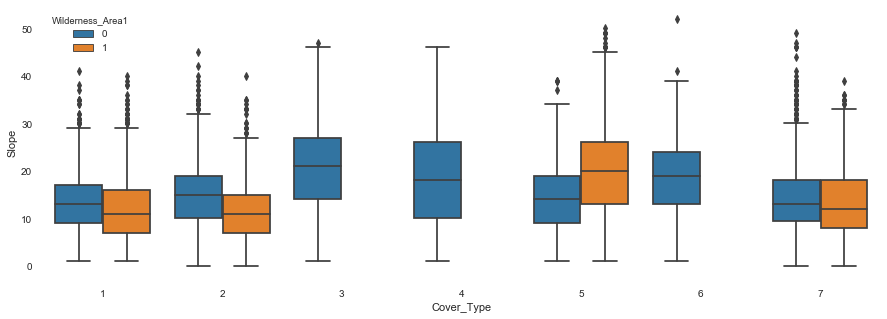

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Cover_Type", y="Slope", hue='Wilderness_Area1',data = df_forest_sample)

## Model Building

### Prepare the data

In [16]:
# Importing Models
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Importing other tools
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

In [17]:
# Defining random seed
seed=42

# Creating Models

lr = LogisticRegression()
lda = LinearDiscriminantAnalysis()
svc = SVC(random_state=seed, probability=True)
dtree = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(10, random_state=seed)
gdb = GradientBoostingClassifier(random_state=seed)
adb = AdaBoostClassifier(random_state=seed)
xgb = XGBClassifier(random_state=seed)
knn = KNeighborsClassifier()
lgbm = LGBMClassifier(random_state=seed)

first_models = [ lr, lda, svc, dtree, 
                 rf, gdb, adb, xgb, knn, lgbm]
first_model_names = ['Logistic Regression','LDA','SVM','Decision Tree', 
                     'Random Forest', 'GradientBoosting',
                    'AdaBoost', 'XGB', 'K-Neighbors','Light GBM'] 

# Defining other steps
n_folds = 5
skf = model_selection.ShuffleSplit(n_splits = n_folds, test_size = .3, train_size = .7, random_state = seed ) 
std_sca = StandardScaler()

In [18]:
#Standardize rows into uniform scale

X = df_forest_sample.drop(['Cover_Type'],axis=1)
y = df_forest_sample['Cover_Type']




### Initial Model building

In [19]:
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df_forest_sample[['Id']]

train_size = X.shape[0]
n_models = len(first_models)
oof_pred = np.zeros((train_size, n_models))
scores = []
row_index=0

for n, model in enumerate(first_models):
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     ('Estimator', model)])
    MLA_name = model.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(model.get_params())
    
    cv_results = model_selection.cross_validate(model, X, y, cv  = skf, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()  
    
    model_pipeline.fit(X, y)
    MLA_predict[MLA_name] = model_pipeline.predict(X)
    row_index+=1
        

In [20]:
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time
9,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.968046,0.863139,2.40357
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.994407,0.841358,0.208693
5,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.861395,0.814462,21.8525
8,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.873828,0.809965,0.0476094
3,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1,0.781041,0.158675
7,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.793802,0.76821,24.2001
1,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.649452,0.650088,0.182985
2,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.55582,0.551235,54.2186
6,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.382559,0.390476,0.921301
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.383371,0.381922,0.92661


In [21]:
MLA_predict.head(10)

,Id,LogisticRegression,LinearDiscriminantAnalysis,SVC,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,XGBClassifier,KNeighborsClassifier,LGBMClassifier
359,360,2,2,2,2,2,2,5,2,2,2
6621,6622,3,3,3,3,3,3,6,3,3,3
11009,11010,3,3,3,3,3,3,6,3,3,3
12784,12785,4,4,4,4,4,4,6,4,4,4
12506,12507,4,4,4,4,4,4,6,4,4,4
11308,11309,3,3,3,3,3,3,3,3,3,3
2228,2229,4,4,4,4,4,4,6,4,4,4
4671,4672,2,2,2,5,5,5,5,5,5,5
1838,1839,1,7,1,1,1,1,7,7,1,1
10931,10932,6,6,6,6,6,6,6,6,6,6


### Understand feature importance

In [22]:
feature_names = X.columns
feat_imp_df = pd.DataFrame(columns=first_model_names, index=feature_names)

# Dropping the Models that don't have feature importances for this analysis
feat_imp_df.drop(['SVM','K-Neighbors'], axis=1, inplace=True)


# I'm using absolute values for logistic Regression and LDA because we only care about the magnitude of the coefficient, not its direction 
#feat_imp_df['Logistic Regression'] = np.abs(lr.coef_.ravel())
#feat_imp_df['LDA'] = np.abs(lda.coef_.flatten())
feat_imp_df['Decision Tree'] = dtree.feature_importances_
feat_imp_df['Random Forest'] = rf.feature_importances_
feat_imp_df['GradientBoosting'] = gdb.feature_importances_
feat_imp_df['AdaBoost'] = adb.feature_importances_
feat_imp_df['XGB'] = xgb.feature_importances_
feat_imp_df['Light GBM'] = lgbm.feature_importances_
feat_imp_df.head()

,Logistic Regression,LDA,Decision Tree,Random Forest,GradientBoosting,AdaBoost,XGB,Light GBM
Id,NaN,NaN,0.064662,0.087523,0.076710,0.00,0.019973,2947
Elevation,NaN,NaN,0.407787,0.214609,0.558882,0.42,0.112055,3139
Aspect,NaN,NaN,0.031397,0.045829,0.006472,0.00,0.008746,852
Slope,NaN,NaN,0.017261,0.031176,0.001211,0.00,0.006702,565
Horizontal_Distance_To_Hydrology,NaN,NaN,0.062224,0.057755,0.041222,0.12,0.023259,1453


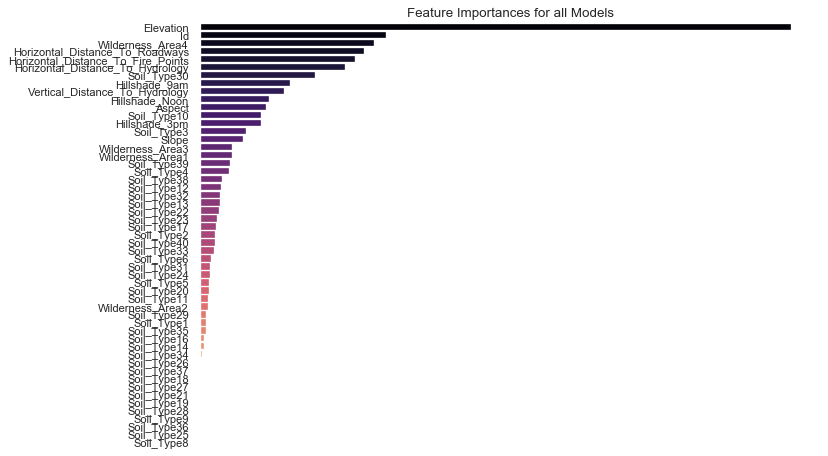

In [23]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

scaled_fi = pd.DataFrame(data=mms.fit_transform(feat_imp_df),
                         columns=feat_imp_df.columns,
                         index=feat_imp_df.index)
scaled_fi['Overall'] = scaled_fi.sum(axis=1)

ordered_ranking = scaled_fi.sort_values('Overall', ascending=False)
fig, ax = plt.subplots(figsize=(10,7), dpi=80)
sns.barplot(data=ordered_ranking, y=ordered_ranking.index, x='Overall', palette='magma')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)
ax.grid(False)
ax.set_title('Feature Importances for all Models');

In [24]:
ordered_ranking.index[:-20:-1]

Index(['Soil_Type8', 'Soil_Type25', 'Soil_Type36', 'Soil_Type9', 'Soil_Type28',
       'Soil_Type19', 'Soil_Type21', 'Soil_Type27', 'Soil_Type18',
       'Soil_Type37', 'Soil_Type26', 'Soil_Type34', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type35', 'Soil_Type1', 'Soil_Type29',
       'Wilderness_Area2', 'Soil_Type11'],
      dtype='object')

In [25]:
train_v2 = df_forest_sample.drop(ordered_ranking.index[:-20:-1], axis=1)

X_v1 = train_v2.drop(['Cover_Type'],axis=1)
y_v1 = train_v2['Cover_Type']



### Model Building after removing irrelevant features

In [26]:
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = train_v2[['Id']]

train_size = X_v1.shape[0]
n_models = len(first_models)
oof_pred = np.zeros((train_size, n_models))
scores = []
row_index=0

for n, model in enumerate(first_models):
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     ('Estimator', model)])
    MLA_name = model.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(model.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(model, X_v1, y_v1, cv  = skf, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()  
    
    model_pipeline.fit(X_v1, y_v1)
    MLA_predict[MLA_name] = model_pipeline.predict(X_v1)
    
    #model_pipeline.fit(X, y)
    #val_pred = model_pipeline.predict(x_val)
    #oof_pred[X, n] = model_pipeline.predict_proba(X)[:,1]
    row_index+=1
        

In [27]:
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time
9,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.968254,0.862875,2.29055
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.994218,0.836949,0.198436
5,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.862358,0.81261,20.6642
8,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.873828,0.809965,0.0271933
3,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1,0.780511,0.135577
7,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.795559,0.76821,16.9012
1,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.644615,0.645811,0.104234
2,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.558957,0.554101,36.3338
6,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.382559,0.390476,0.819138
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.384921,0.383818,0.664556


### GridSearchCV

In [28]:
first_models = [rf,lgbm,knn]
first_model_names = ['rf','lgbm', 'knn'] 

In [29]:
LGBM_param_grid = {'lgbm__learning_rate': [0.1],
    'lgbm__n_estimators': [100],
    'lgbm__num_leaves': [31], # large num_leaves helps improve accuracy but might lead to over-fitting
    'lgbm__boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    
                  }

RF_param_grid = {
                
               'rf__n_estimators': [100,200], #default=10
            'rf__criterion': ['gini', 'entropy'], #default=”gini”
            'rf__max_depth': [2,4,8] ,#default=None
            'rf__oob_score': ['True']
}

GDB_param_grid = {
    "gdb__loss":["deviance"],
    "gdb__learning_rate": [0.01,0.1],
    
    "gdb__max_depth":[3,5],
   
    "gdb__criterion": ["friedman_mse",  "mae"],
    
    "gdb__n_estimators":[10]
    
}
XGB_param_grid = {
    'xgb__min_child_weight': [1, 5],
        'xgb__gamma': [0.5, 1],
        'xgb__max_depth': [3, 4, 5]
}

KNN_param_grid = {
    'knn__n_neighbors':[5,6,7],
          'knn__leaf_size':[1,2,3,5],
          
}

In [30]:
from sklearn.model_selection import GridSearchCV
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
#models = [LGBMClassifier(),RandomForestClassifier()]
params_grid = [RF_param_grid,LGBM_param_grid,KNN_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for n,alg in enumerate(first_models):
    print(alg)
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     (first_model_names[n], first_models[n])])
    
    gs_alg = GridSearchCV(model_pipeline, param_grid = params_grid[0], cv = skf, scoring = 'accuracy', n_jobs=-1,return_train_score=True)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_v1, y_v1)
   
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
 
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = gs_alg.cv_results_['mean_train_score'][gs_alg.best_index_]
    after_model_compare.loc[row_index, 'Test Accuracy'] = gs_alg.cv_results_['mean_test_score'][gs_alg.best_index_]
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

after_model_compare

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
1 RandomForestClassifier trained...
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsamp

,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,RandomForestClassifier,"{'rf__criterion': 'entropy', 'rf__max_depth': ...",0.808277,0.773148
1,LGBMClassifier,"{'lgbm__boosting_type': 'gbdt', 'lgbm__learnin...",0.968972,0.862831
2,KNeighborsClassifier,"{'knn__leaf_size': 1, 'knn__n_neighbors': 5}",0.840684,0.759788


### Stacking

#### Through voting classifier

In [31]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    
    ('rfc', ensemble.RandomForestClassifier()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier()),
   ('lgbm',LGBMClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X, y, cv  = skf)
vote_hard.fit(X, y)
#print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X, y, cv  = skf)
vote_soft.fit(X, y)

#print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Test w/bin score mean: 86.38
Hard Voting Test w/bin score 3*std: +/- 0.80
----------
Soft Voting Test w/bin score mean: 87.25
Soft Voting Test w/bin score 3*std: +/- 0.93
----------


#### Through mlxtend

In [33]:
!pip install mlxtend  

     |███████████████████████████▏    | 1.1 MB 86 kB/s eta 0:00:030ERROR: Exception:
Traceback (most recent call last):
  File "/Users/Niharika/opt/anaconda3/lib/python3.7/site-packages/pip/_vendor/urllib3/contrib/pyopenssl.py", line 313, in recv_into
    return self.connection.recv_into(*args, **kwargs)
  File "/Users/Niharika/opt/anaconda3/lib/python3.7/site-packages/OpenSSL/SSL.py", line 1822, in recv_into
    self._raise_ssl_error(self._ssl, result)
  File "/Users/Niharika/opt/anaconda3/lib/python3.7/site-packages/OpenSSL/SSL.py", line 1622, in _raise_ssl_error
    raise WantReadError()
OpenSSL.SSL.WantReadError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Niharika/opt/anaconda3/lib/python3.7/site-packages/pip/_vendor/urllib3/contrib/pyopenssl.py", line 313, in recv_into
    return self.connection.recv_into(*args, **kwargs)
  File "/Users/Niharika/opt/anaconda3/lib/python3.7/site-packages/OpenSSL/SSL.py", li

You should consider upgrading via the '/Users/Niharika/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [34]:
from mlxtend.classifier import StackingClassifier

In [35]:
lgbm_cl = LGBMClassifier(random_state=seed)
lgbm_cl.set_params = after_model_compare['Parameters'][1]

In [36]:
rf_cl = RandomForestClassifier(10, random_state=seed)

In [37]:
gdb_cl = GradientBoostingClassifier(random_state=seed)

In [38]:
logreg = LogisticRegression()

In [39]:
sclf = StackingClassifier(classifiers=[lgbm_cl, rf_cl,gdb_cl],
                          meta_classifier=logreg)

label = ['LGBM', 'Random Forest','GDB' 'Stacking Classifier']
clf_list = [lgbm_cl, rf_cl,gdb_cl, logreg]

In [40]:
for clf, label in zip([lgbm_cl, rf_cl,gdb_cl,sclf], 
                      ['LGBM', 
                       'Random Forest', 
                       'GDB',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_v1, y_v1, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.86 (+/- 0.00) [LGBM]
Accuracy: 0.83 (+/- 0.00) [Random Forest]
Accuracy: 0.81 (+/- 0.00) [GDB]
Accuracy: 0.81 (+/- 0.01) [StackingClassifier]


In [41]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19877 sha256=c1db0659465917532ef2cf0d6da9eeff1e4617d7dc52db1665f52a3132162d76
  Stored in directory: /Users/Niharika/Library/Caches/pip/wheels/28/fe/0c/fe8e43660e3316d7ce204e59a79a72246c0ae9b6c5c79841c8
Successfully built vecstack
You should consider upgrading via the '/Users/Niharika/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


#### Through vecstack

In [43]:
from vecstack import stacking

In [44]:
#1st level model
X_train, X_test, y_train, y_test = train_test_split(X_v1, y_v1, test_size=0.2)

models = [lgbm_cl,rf_cl,gdb_cl]
S_train, S_test = stacking(models, X_train, y_train, X_test, 
    regression = False, metric = accuracy_score, n_folds = 4 , 
    shuffle = True, random_state = 0, verbose = 2)

task:         [classification]
n_classes:    [7]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LGBMClassifier]
    fold  0:  [0.85515873]
    fold  1:  [0.85813492]
    fold  2:  [0.85548942]
    fold  3:  [0.85185185]
    ----
    MEAN:     [0.85515873] + [0.00223061]
    FULL:     [0.85515873]

model  1:     [RandomForestClassifier]
    fold  0:  [0.82771164]
    fold  1:  [0.81812169]
    fold  2:  [0.82738095]
    fold  3:  [0.82043651]
    ----
    MEAN:     [0.82341270] + [0.00421546]
    FULL:     [0.82341270]

model  2:     [GradientBoostingClassifier]
    fold  0:  [0.80820106]
    fold  1:  [0.81580688]
    fold  2:  [0.80257937]
    fold  3:  [0.80390212]
    ----
    MEAN:     [0.80762235] + [0.00516220]
    FULL:     [0.80762235]



In [45]:
#2nd level model
models = [xgb]
S_train, S_test = stacking(models, S_train, y_train, S_test, 
    regression = False, metric = accuracy_score, n_folds = 4 , 
    shuffle = True, random_state = 0, verbose = 2)

task:         [classification]
n_classes:    [7]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [XGBClassifier]
    fold  0:  [0.85515873]
    fold  1:  [0.85615079]
    fold  2:  [0.85449735]
    fold  3:  [0.84755291]
    ----
    MEAN:     [0.85333995] + [0.00339257]
    FULL:     [0.85333995]

